In [1]:
from IPython.core.display import HTML
import urllib.request
HTML(urllib.request.urlopen('http://bit.ly/1Bf5Hft').read().decode('utf-8'))

In [40]:
import pandas as pd 
import numpy as np
import time

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Machine Learning 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
import itertools

# Metrics
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score, recall_score, classification_report

# Plotting 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# Supress warnings
import warnings; warnings.simplefilter('ignore')

In [3]:
df = pd.read_pickle('agg_data/classfication_df.pkl') 

#### Table of contents


##### [Feature engineering](#dimensionality_reduction)

##### [Training, validation & testing](#training)

##### [Performance comparison](#performance)

##### [Conclusion](#conclusion)


Let's first take a look at the data and perform feature selection.

### Feature engineering<a id='dimensionality_reduction'></a>


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423844 entries, 0 to 423843
Data columns (total 47 columns):
loan_amnt                     423844 non-null int64
funded_amnt                   423844 non-null int64
funded_amnt_inv               423844 non-null float64
term                          423844 non-null int64
int_rate                      423844 non-null float64
installment                   423844 non-null float64
grade                         423844 non-null object
sub_grade                     423844 non-null object
emp_length                    423844 non-null float64
home_ownership                423844 non-null object
annual_inc                    423844 non-null float64
verification_status           423844 non-null object
loan_status                   423844 non-null object
purpose                       423844 non-null object
title                         423844 non-null object
addr_state                    423844 non-null object
dti                           423844 no

The goal of this analysis is to predict which loans will default. We set it up as a binary classfication problem with label being `loan_status`. We will only consider completed loans and loans which have either been paid off or have been charged off. 

In [5]:
df = df[(df["loan_status"] == "Fully Paid") |
                            (df["loan_status"] == "Charged Off")]


Let's pay attention to features which leak information from the future (i.e after the loan has been funded). These features won't be available to the lender at the time of origination. We will drop them. 

In [6]:
leak_frm_ftr = ['total_pymnt', 
                'total_pymnt_inv', 
                'total_rec_prncp', 
                'total_rec_int', 
                'total_rec_late_fee', 
                'last_pymnt_amnt',
                'out_prncp', 
                'out_prncp_inv', 
                'recoveries',                     
                'collection_recovery_fee'
                   ] 

In [7]:
df.drop(leak_frm_ftr, axis=1, inplace=True)

Let us now focus on another category, state of address of the borrower. Let's see how many unique states are there in the dataset.

In [8]:
df.addr_state.unique()

array(['FL', 'CA', 'NM', 'MI', 'NC', 'CT', 'NY', 'MA', 'CO', 'TX', 'SC',
       'DE', 'PA', 'OH', 'UT', 'IN', 'AZ', 'NJ', 'GA', 'MO', 'IL', 'WI',
       'WA', 'VA', 'MN', 'MD', 'KY', 'WY', 'TN', 'NV', 'NH', 'KS', 'RI',
       'AL', 'LA', 'WV', 'OR', 'VT', 'AR', 'OK', 'HI', 'MT', 'AK', 'SD',
       'DC', 'NE', 'IA', 'MS', 'ID', 'ME'], dtype=object)

We notice that there are 50 unique categories within this feature. This makes sense since Lending Club does not allow lending in North Dakota. 

My first instinct was to drop this variable altogether, because of its very broad levels. Intuitively, the state of residence of borrower is an important variable since it affects monthly income (income taxes vary by state), property taxes (and this in turn affects real estate payment) and a combination of these might influence debt-to-income ratio. The FICO score presumably should also depend on state, and as such it stands to reason that the geographical location plays a subtle and an important role in influencing other features, and eventually the chance of getting a loan originated. But, as mentioned before, there are 50 categories within this variable which will result in a marked increase in model complexity and time for training. 

To incorporate the effect of State on the eventual outcome, I engineered a new boolean feature `IsltiBetterThanMedian`. This is 1 if a borrower has a better than median loan-to-income ratio among all other borrowers grouped by state. I chose loan-to-income ratio to engineer this feature since it better incorporates the interaction of other features among themselves. 

In [9]:
median_lti_by_state = df.groupby("addr_state")[["lti"]].transform('median')["lti"]
df["IsltiBetterThanMedian"] = (df["lti"] > median_lti_by_state).astype(int)

Let's now remove the State variable.

In [10]:
df.drop(["addr_state"], axis=1, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397020 entries, 0 to 423842
Data columns (total 37 columns):
loan_amnt                     397020 non-null int64
funded_amnt                   397020 non-null int64
funded_amnt_inv               397020 non-null float64
term                          397020 non-null int64
int_rate                      397020 non-null float64
installment                   397020 non-null float64
grade                         397020 non-null object
sub_grade                     397020 non-null object
emp_length                    397020 non-null float64
home_ownership                397020 non-null object
annual_inc                    397020 non-null float64
verification_status           397020 non-null object
loan_status                   397020 non-null object
purpose                       397020 non-null object
title                         397020 non-null object
dti                           397020 non-null float64
delinq_2yrs                   397020 n

We have extracted out relevant features from loan titles. Let's drop that feature.

In [12]:
df.drop('title', axis=1, inplace=True)

Some closely related features still remain. For instance, `total_acc`, `open_acc` are related. `pub_rec` and `pub_rec-bankruptcies` are also related and so are `acc_now_delinq` and `delinq_amnt`. Let's choose only one feature among each of these
categories.
<br>
<br>
`pub_rec` offers a more complete history of the borrower. Let's keep it. `delinq_amnt` is more indicative of future expected paymemts as compared to `acc_now_delinq`. Similarly `open_acc` would be more indicative of future payments compared to `total_acc`. `loan_amnt`, `funded_amnt` and `funded_amnt_inv` are also related. `funded_amnt` is the most relevant.Let's keep these features and drop the extraneous ones

In [13]:
df.drop(['total_acc', 'acc_now_delinq', 'loan_amnt', 'funded_amnt_inv', 'pub_rec_bankruptcies'], axis=1, inplace=True)

In [14]:
#df.collections_12_mths_ex_med.value_counts() <- This feature is mostly zero
#df.chargeoff_within_12_mths.value_counts() <- This feature is mostly zero

These features are mostly zero and won't have any predictive power. Let's drop them

In [15]:
df.drop(['collections_12_mths_ex_med', 'chargeoff_within_12_mths'], axis=1, inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397020 entries, 0 to 423842
Data columns (total 29 columns):
funded_amnt              397020 non-null int64
term                     397020 non-null int64
int_rate                 397020 non-null float64
installment              397020 non-null float64
grade                    397020 non-null object
sub_grade                397020 non-null object
emp_length               397020 non-null float64
home_ownership           397020 non-null object
annual_inc               397020 non-null float64
verification_status      397020 non-null object
loan_status              397020 non-null object
purpose                  397020 non-null object
dti                      397020 non-null float64
delinq_2yrs              397020 non-null int64
inq_last_6mths           397020 non-null int64
open_acc                 397020 non-null int64
pub_rec                  397020 non-null int64
revol_bal                397020 non-null int64
revol_util               39

##### Feature selection & Dimensionality Reduction 

Feature selection is critical to building a good model, for several reasons. One is that feature selection implies some sort of cardinality reduction, to impose a cutoff on the number of attributes that can be considered when building a model. This can help in mitigating overfitting by selecting only the most important attributes, reduce training time and result in better model interpretability.  Selecting the most important predictive features from a large space can be tricky.
<br>
<br>
For any given data set, there are a host of supervised and unsupervised feature selection and dimensionality reduction techniques one can use. Filter, Wrapper and Embedded Methods allow us to perform supervised feature selection while PCA is a common example of unsupervised feature selection. 
<br>
<br>
Filter Methods consider the relationship between features and the target variable to compute the importance of features. Within filter methods, we can use F-test and variance threshold (which is actually an unsupervised technique) to select a subset of best features. I ruled out variance threshold since it removes features with variation below a certain cut-off. This might remove features which are ordinal or categorical, since such features don't vary much. Our dataset has a lot of categorical and ordinal features, and it will be risky to remove them using a technique which looks for variation among variables and does not peek into the labels.  F-Test is useful in feature selection as we get to know the significance of each feature in improving the model. F-Test checks for and only captures linear relationships between features and labels. A highly correlated feature is given higher score and less correlated features are given lower score. Using summary statistics like correlation may be a bad idea, as illustrated by Anscombe’s quartet. I decided not to use F-test for feature selection. Mutual info classification could be a promising way to perform feature selection since it does well with non-linear reltionship between feature and label. This function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances. But, I feel that such techniques rank each feature independently of the feature space, which not be appropriate for this dataset that has dependencies among features. 
<br>
<br>
Wrapper Methods generate models with a subsets of feature and gauge their model performances. However, the main drawback of wrapper methods is the sheer amount of models that needs to be trained. It can be computationally very expensive and decided not to use them. 
<br>
<br>
PCA is a form of unsupervised feature selection technique, which tries to minimize variance. The correlation of features with each principal component has nothing to do with the dependent variable. Technically, one can use PCA on categorical data (e.g. one-hot encoded data), but that would not be the correct approach.  PCA finds directions of highest variance and makes Gaussian assumptions about the data via its use of the covariance matrix. Using PCA for the given dataset which has a lots of categorical features is not meaningful. 
<br>
<br>
I feel that feature selection using Embedded methods would be the best approach here. Such methods perform variable selection as part of the learning procedure. The given dataset has a lot of features that are closely (linearly and non-linearly) related to each other. 
<br>
<br>

#### Encoding

First we need to convert our categorical features in to numerical features, since *scikit-learn's* classification algorithms require numerical features. We could use either integer encoding or one-hot encoding to convert our categorical data to numerical data. For ordinal features like `grade`, integer encoding makes sense as there is a natural order among the feature categories. 
<br>
<br>
For categorical variables where no such ordinal relationship exists, the integer encoding is not enough. In fact, using this encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results. For such variables, we will use one-hot encoding.

In [17]:
df.select_dtypes(include=['object']).head(10)

,grade,sub_grade,home_ownership,verification_status,loan_status,purpose,initial_list_status
0,B,B4,RENT,Verified,Fully Paid,debt_consolidation,f
1,A,A3,MORTGAGE,Source Verified,Fully Paid,debt_consolidation,w
2,E,E4,RENT,Verified,Fully Paid,debt_consolidation,f
3,B,B5,RENT,Source Verified,Fully Paid,debt_consolidation,w
4,B,B5,MORTGAGE,Verified,Fully Paid,credit_card,w
5,A,A5,MORTGAGE,Not Verified,Fully Paid,debt_consolidation,w
6,B,B4,RENT,Not Verified,Fully Paid,debt_consolidation,f
7,A,A2,MORTGAGE,Not Verified,Fully Paid,debt_consolidation,w
8,B,B2,RENT,Not Verified,Fully Paid,debt_consolidation,f
9,B,B5,RENT,Verified,Fully Paid,debt_consolidation,f


In [18]:
categorical_vars = ['home_ownership', 'verification_status', 'purpose', 'initial_list_status']
df = pd.get_dummies(df, columns=categorical_vars)


In [19]:
df.replace(to_replace={"grade": {"A": 7, "B": 6, "C": 5, "D": 4, 
                                       "E": 3, "F": 2, "G": 1}}, inplace=True)

Let's integer encode the subgrade too. There are a totals of 35 sub-grades. We will use the same sort of encoding as for `grade`. Less risky loans get higher rank. 

In [20]:
keys = sorted(df.sub_grade.unique())
values = list(reversed(range(1, 36)))
df.replace(to_replace={'sub_grade': dict(zip(keys,values))}, inplace=True)

### Training, validation & testing <a id='training'></a>

We now randomly split our data in to training and testing sets. We will use the training set to train and validate our models and the independent test set to assess the classifier's performance. We split the data in a stratified fashion to make sure that the random split has similar proportion of class labels (in train and test sets) as in the full data-set.

In [21]:
mapping_dict = {'loan_status':{'Fully Paid': 0, 'Charged Off': 1}}
df = df.replace(mapping_dict)

In [22]:
features = df.drop("loan_status", axis=1)
labels = df["loan_status"]

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, 
                                                                            test_size=0.2, 
                                                                            random_state=42,
                                                                            stratify=labels) 

Instead of k-fold cross validation, we will use stratified split for validation. Stratification seeks to ensure that each fold is representative of all strata of the data. Generally this is done in a supervised way for classification and ensures each class is (approximately) equally represented across each test fold (which are of course combined in a complementary way to form training folds). Stratification is the process of rearranging the data as to ensure each fold is a good representative of the whole. To counter the imbalance in our labels, we will use a technique called Stratified Shuffle Split for validating our model. 


In [23]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42) # 5 splits with 80-20 split

Feature selection and classification algorithms which depend on a notion of distance (SVM, regularized logistic regression, k-nearest neighbors) require scaling, while  tree-based algorithms (decision trees and random forests) are not affected by scaling. In such cases, not only is scaling not necessary, it can smooth out the nonlinear nature of the model.
<br>
<br>
My broad line of attack for this problem is to consider two different types of feature selection and classification algorithms. We will consider two different sets of training/ testing data for each of these techniques. 
<br>
<br>
#### Classifers

Let's start with linear classifers, which depend on notion of a distance. For such classifiers, it is important to normalize the features before performing feature selection. Instead of standardaizing with 0 mean and unit variance, we will rescale the data so that all features lie in [0, 1]. Another advantage of re-scaling over standardization is that re-scaling leaves boolean variables intact.

In [24]:
scaler = MinMaxScaler()
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

*A small note on cross-validation and workflow*
<br>
<br>
In sklearn, the `GridSearchCV` class is a convenient way of pulling off  parameter selection. When fed training data, it will perform multiple training-validation splits and fit a selected algorithm or pipeline to these splits, selecting a parameter set that has the best overall performance on the validation sets. 
<br>
<br>
By default, `GridSearchCV` performs 3-fold cross-validation, but we can also set different cross-validation or scoring functions. We will use roc-auc as scoring function for the validation step. We will use the previously created `StratifiedShuffleSplit`  object as the cross-validation function. When we use `GridSearchCV`, the validation is performed internally. We don't use a test/train split to validate our model. The optimal model is selected by `GridSearchCV` based on the internal train/validation subsets that it creates automatically.
<br>
<br>
We will also use the `Pipeline` module from `scikit-learn` which allows us to chain transformers and estimators together in such a way that one can use them as a single unit. 

##### Logistic Regression with L2 penalty

In [27]:
t0 = time.time()
pipeline_lgr = Pipeline([('classify', LogisticRegression(random_state=0, 
                                                         class_weight='balanced',
                                                         penalty='l2'))
                        ])
param_grid_lgr =  [{'classify__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}]
gs_lgr = GridSearchCV(pipeline_lgr, 
                      param_grid=param_grid_lgr, 
                      scoring='recall', 
                      cv=sss)
print("\nPerforming grid search for Logistic Regression classifier over hyperparameters...")
gs_lgr.fit(features_train_scaled, labels_train)
    
print(' LGR:\n {}\n'.format(classification_report(labels_test,
                                                           gs_lgr.best_estimator_.predict(features_test_scaled))))
t1 = time.time()


Performing grid search for Logistic Regression classifier over hyperparameters...
 LGR:
              precision    recall  f1-score   support

          0       0.89      0.68      0.77     65580
          1       0.29      0.62      0.39     13824

avg / total       0.79      0.67      0.71     79404




In [28]:
lgr_time = t1 - t0 
gs_lgr.best_estimator_ # This is the model with the best mean recall

Pipeline(memory=None,
     steps=[('classify', LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [29]:
fpr_lgr, tpr_lgr, _ = roc_curve(labels_test, 
                                gs_lgr.best_estimator_.decision_function(features_test_scaled),
                                pos_label=1)
precision_lgr, recall_lgr, _ = precision_recall_curve(labels_test, 
                                                      gs_lgr.best_estimator_.decision_function(features_test_scaled))
roc_lgr = roc_auc_score(labels_test, gs_lgr.best_estimator_.decision_function(features_test_scaled))

In [30]:
roc_lgr

0.7027220120251771

##### Modified Huber

In [31]:
t0 = time.time()
pipeline_huber = Pipeline([('classify', SGDClassifier(random_state=0, 
                                                      class_weight='balanced',
                                                      loss='modified_huber',
                                                      penalty='l1'))
                        ])
param_grid_huber =  [{'classify__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}]
gs_huber = GridSearchCV(pipeline_huber, 
                      param_grid=param_grid_huber, 
                      scoring='recall', 
                      cv=sss)
print("\nPerforming grid search for Modified Huber classifier over hyperparameters...")
gs_huber.fit(features_train_scaled, labels_train)
    
print(' Huber:\n {}\n'.format(classification_report(labels_test,
                                                           gs_huber.best_estimator_.predict(features_test_scaled))))
t1 = time.time()


Performing grid search for Modified Huber classifier over hyperparameters...
 Huber:
              precision    recall  f1-score   support

          0       0.89      0.67      0.77     65580
          1       0.28      0.61      0.39     13824

avg / total       0.78      0.66      0.70     79404




In [32]:
huber_time = t1 - t0 
gs_huber.best_estimator_ 

Pipeline(memory=None,
     steps=[('classify', SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=None, n_jobs=1, penalty='l1', power_t=0.5, random_state=0,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

In [54]:
fpr_huber, tpr_huber, _ = roc_curve(labels_test, 
                                gs_huber.best_estimator_.decision_function(features_test_scaled),
                                pos_label=1)
precision_huber, recall_huber, _ = precision_recall_curve(labels_test, 
                                                      gs_huber.best_estimator_.decision_function(features_test_scaled))
roc_huber = roc_auc_score(labels_test, gs_huber.best_estimator_.decision_function(features_test_scaled))

##### Random Forests

In [41]:
t0 = time.time()
pipeline_rf = Pipeline([
    ('classify', RandomForestClassifier(random_state=0,
                                        class_weight={0:1, 1:5}, # Ratio of default/ non-default
                                        n_jobs=-1))
])
param_grid_rf = [
    {
        #'classify__criterion' : ['gini', 'entropy'],
        'classify__max_depth':  [None, 5, 10, 50, 100, 150]
        #'classify__n_estimators': [10, 20, 30, 40, 50]
    }
]
gs_rf = GridSearchCV(pipeline_rf, 
                     param_grid=param_grid_rf, 
                     scoring='recall',
                     cv=sss)
gs_rf.fit(features_train_scaled, labels_train)
print(' Random Forest:\n {}\n'.format(classification_report(labels_test,
                                                           gs_rf.best_estimator_.predict(features_test_scaled))))
t1 = time.time()

 Random Forest:
              precision    recall  f1-score   support

          0       0.90      0.58      0.71     65580
          1       0.26      0.71      0.38     13824

avg / total       0.79      0.60      0.65     79404




In [42]:
rf_time = t1 - t0 
gs_rf.best_estimator_ 

Pipeline(memory=None,
     steps=[('classify', RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 5},
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False))])

In [43]:
fpr_rf, tpr_rf, _ = roc_curve(labels_test, 
                                gs_rf.best_estimator_.predict_proba(features_test_scaled)[:,1], 
                                pos_label=1)
precision_rf, recall_rf, _ = precision_recall_curve(labels_test, 
                                                      gs_rf.best_estimator_.predict_proba(features_test_scaled)[:, 1])
roc_rf = roc_auc_score(labels_test, gs_rf.best_estimator_.predict_proba(features_test_scaled)[:, 1])

In [44]:
roc_rf

0.6980165769975956

##### Extra trees classifier 

In [48]:
t0 = time.time()
pipeline_et = Pipeline([
    ('classify', ExtraTreesClassifier(random_state=0,
                                        class_weight={0:1, 1:5}, # Ratio of default/ non-default
                                        criterion='entropy',
                                        n_jobs=-1))
])
param_grid_et = [
    {
        #'classify__criterion' : ['gini', 'entropy'],
        'classify__max_depth':  [None, 5, 10, 50, 100, 150]
        #'classify__n_estimators': [10, 20, 30, 40, 50]
    }
]
gs_et = GridSearchCV(pipeline_et, 
                     param_grid=param_grid_et, 
                     scoring='recall',
                     cv=sss)
gs_et.fit(features_train_scaled, labels_train)
print(' Extra trees:\n {}\n'.format(classification_report(labels_test,
                                                           gs_et.best_estimator_.predict(features_test_scaled))))
t1 = time.time()

 Extra trees:
              precision    recall  f1-score   support

          0       0.89      0.65      0.75     65580
          1       0.28      0.63      0.39     13824

avg / total       0.79      0.65      0.69     79404




In [49]:
gs_et.estimator

Pipeline(memory=None,
     steps=[('classify', ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 5},
           criterion='entropy', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False))])

In [50]:
et_time = t1 - t0 
gs_et.best_estimator_ 

Pipeline(memory=None,
     steps=[('classify', ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 5},
           criterion='entropy', max_depth=10, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False))])

In [51]:
fpr_et, tpr_et, _ = roc_curve(labels_test, 
                                gs_et.best_estimator_.predict_proba(features_test_scaled)[:,1], 
                                pos_label=1)
precision_et, recall_et, _ = precision_recall_curve(labels_test, 
                                                      gs_et.best_estimator_.predict_proba(features_test_scaled)[:, 1])
roc_et = roc_auc_score(labels_test, gs_et.best_estimator_.predict_proba(features_test_scaled)[:, 1])

### Performance comparison <a id='performance'></a>

Let us compare the performace of the various classifiers. Let us start by plotting the ROC-AUC curve.

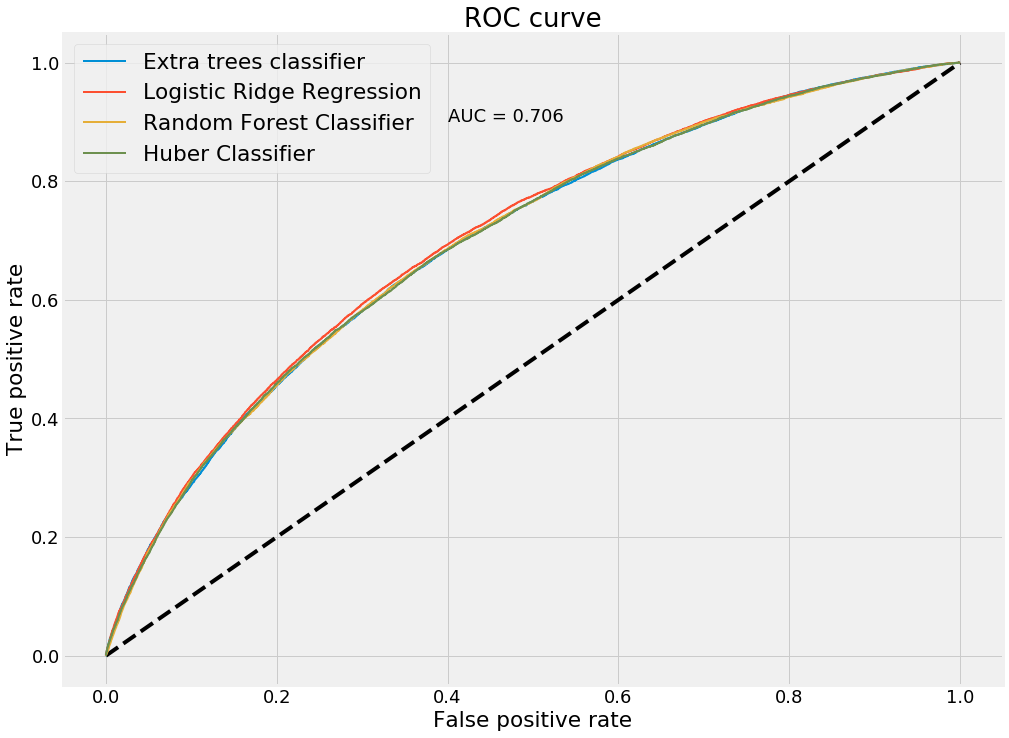

In [55]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(15, 12))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_et, tpr_et, linewidth=2, label='Extra trees classifier')
plt.plot(fpr_lgr, tpr_lgr, linewidth=2, label='Logistic Ridge Regression')
plt.plot(fpr_rf, tpr_rf, linewidth=2, label='Random Forest Classifier')
plt.plot(fpr_huber, tpr_huber, linewidth=2, label='Huber Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best', fontsize = 'large')
plt.text(0.4, 0.9, 'AUC = 0.706')
plt.savefig('roc_final')

Let us now plot the precison recall curve.

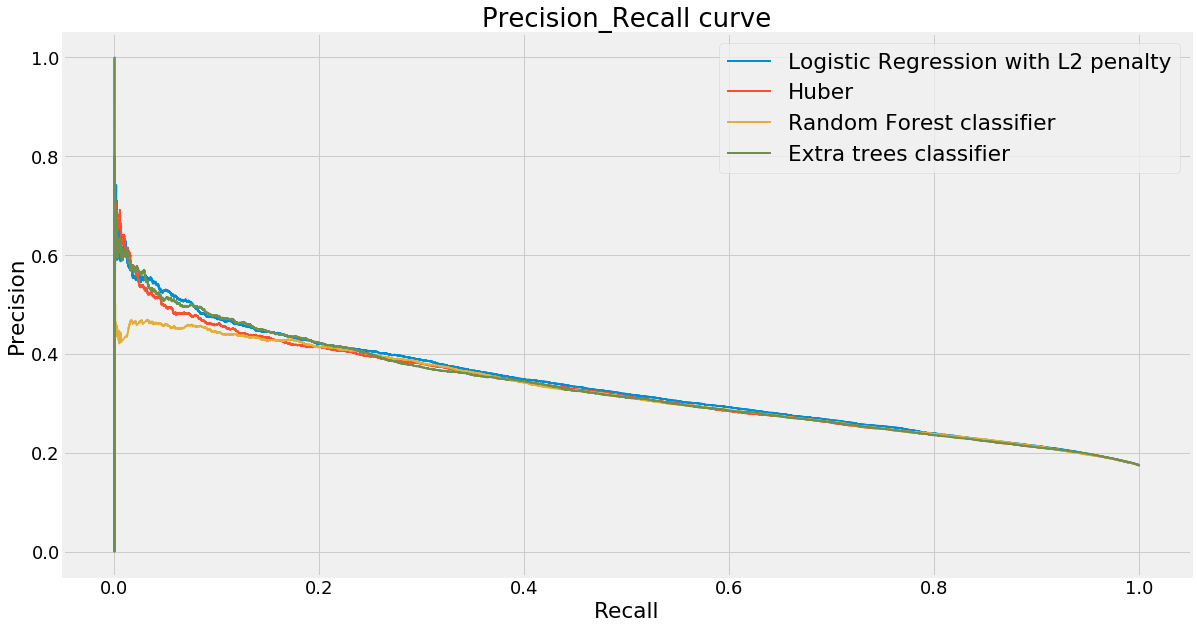

In [56]:
plt.figure(figsize=(18, 10))
plt.plot(recall_lgr, precision_lgr, linewidth=2, label='Logistic Regression with L2 penalty')
plt.plot(recall_huber, precision_huber, linewidth=2, label='Huber')
plt.plot(recall_rf, precision_rf, linewidth=2, label='Random Forest classifier')
plt.plot(recall_et, precision_et, linewidth=2, label='Extra trees classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall curve')
plt.legend(loc='best', fontsize = 'large')
plt.show()

Here is the precision, recall and f1-score for each class. 

Normalized confusion matrix
[[0.67932296 0.32067704]
 [0.38469329 0.61530671]]


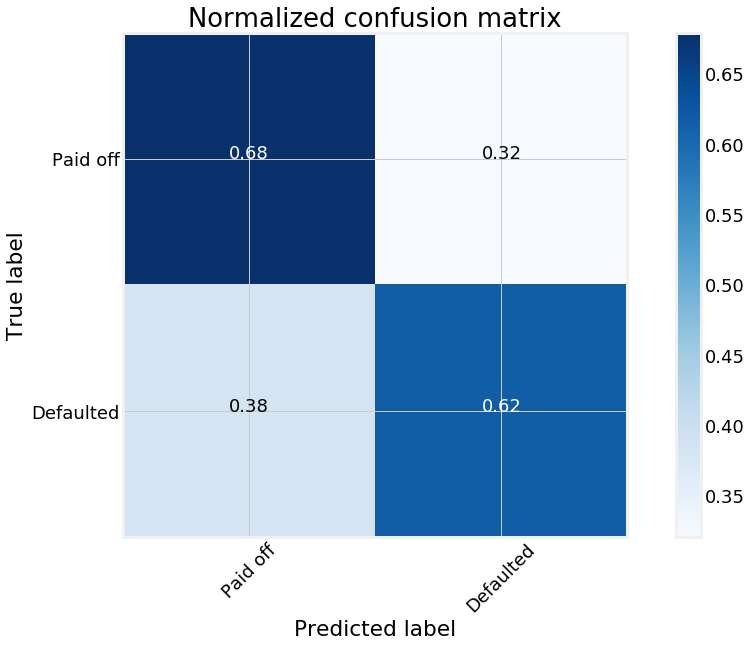

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
                          #cmap=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    #thresh = cm.max() / 3.
    thresh =0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] < thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(labels_test,
                              gs_lgr.predict(features_test_scaled))
# Plot normalized confusion matrix
plt.figure(figsize=(14,9))
plot_confusion_matrix(cnf_matrix, classes=['Paid off', 'Defaulted'], normalize=True,
                      title='Normalized confusion matrix')

#plt.savefig('confusion1')

In [58]:
print('LGR:\n {}\n'.format(classification_report(labels_test,
                                                           gs_lgr.best_estimator_.predict(features_test_scaled))))
print(' Huber:\n {}\n'.format(classification_report(labels_test,
                                                           gs_huber.best_estimator_.predict(features_test_scaled))))

print(' Random Forest:\n {}\n'.format(classification_report(labels_test,
                                                           gs_rf.best_estimator_.predict(features_test_scaled))))
print(' Extra trees:\n {}\n'.format(classification_report(labels_test,
                                                           gs_et.best_estimator_.predict(features_test_scaled))))

LGR:
              precision    recall  f1-score   support

          0       0.89      0.68      0.77     65580
          1       0.29      0.62      0.39     13824

avg / total       0.79      0.67      0.71     79404


 Huber:
              precision    recall  f1-score   support

          0       0.89      0.67      0.77     65580
          1       0.28      0.61      0.39     13824

avg / total       0.78      0.66      0.70     79404


 Random Forest:
              precision    recall  f1-score   support

          0       0.90      0.58      0.71     65580
          1       0.26      0.71      0.38     13824

avg / total       0.79      0.60      0.65     79404


 Extra trees:
              precision    recall  f1-score   support

          0       0.89      0.65      0.75     65580
          1       0.28      0.63      0.39     13824

avg / total       0.79      0.65      0.69     79404




In [60]:
roc_auc_df = pd.DataFrame([
                          ['Logistic Ridge Regression', roc_lgr, lgr_time],
                          ['Huber classifer', roc_huber, huber_time],
                          ['Random Forests', roc_rf, rf_time],
                          ['Extra trees', roc_et, et_time]
                         ], 
                         columns=['Classifier', 'Test ROC AUC', 'Training time'])

In [61]:
roc_auc_df

,Classifier,Test ROC AUC,Training time
0,Logistic Ridge Regression,0.702722,536.467445
1,Huber classifer,0.697351,74.690947
2,Random Forests,0.698017,84.317155
3,Extra trees,0.697392,105.786773


All the classifiers perform reasonably well with respect to auc. We notice that the training time for the Huber classifer is substantially low, since it uses stochastic gradient descent.
<br>
<br>
The goal of this exercise is to classify as many correct instances of canceled loans so that the bad loans are avoided. (As an investor, we also need to correctly identify the loans which will eventually be paid off, but that is a seperate problem.) Since our original data is skewed in favor of paid off loans (thereby causing an imbalance in class labels), let us also look at precision and recall of the classifiers. 
<br>
<br>
Within the class of defaulted loans (label 1), the ensemble classfiers have a very poor recall (percentage of class 1 labels that were correctly identified) and near perfect precision (percentage of positive predictions that were correct).  The auc for these ensemble methods is low and these classifiers perform poorly. Within the class of defaulted loans, linear classifiers significantly outperform the ensemble classifiers with respect to recall. Note that the ensemble classifiers seem to label most of the loans as approved.
<br>
<br>
Overall, the performance of the classifiers is decent. Better feature selection techniques and more parameter tuning can improve the performance. Logistic Ridge Regression performs the best. 

### Conclusion <a id='conclusion'></a>

Let's wrap things up. I'm reasonably satisfied with this preliminary analysis. Our recall needs more work. There are a few things that can be tried to improve the predictive performance. I list some of them here.
<br>
1. More work needs to be done in the data pre-processing part, and this is very crucial. A lot of decisions with respect to keeping or throwing variables were attributed to intuition or common logic. A more structured approach needs to be taken with regards to how features interact among themselves, and how different features are calculated by Lending Club. 
<br>
<br>
2. Seeing that there were groups of closely related variables, perhaps a grouped lasso feature selection might work better. The lasso solution is not satisfactory as it only selects individual dummy variables instead of whole factors. Moreover, the lasso solution depends on how the dummy variables are encoded. Choosing different contrasts for a categorical predictor will produce different solutions in general. Grouped lasso has the attractive property that it does variable selection at the group level.
<br>
<br>
3. We performed one-hot encoding for our categorical features. Decision tree models can handle categorical variables without one-hot encoding them. However, popular implementations of decision trees (and random forests) differ as to whether they honor this fact. (sklearn pre-supposed one-hot encoding). One-hot encoding also presents two problems that are more particular to tree-based models:
<br>
<br>
  (a) The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.
    
   (b) A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance. One can try using `h2o` library in python, which does not presuppose one-hot encoding, for tree based methods. 
<br>
<br>
4. Validate over a larger grid of hyper-parameters to get a better tuned classification model. Also optimize over the parameters of feature selection technique. Note that all of our classifiers performed poorly. A better tuned model might help. This increases the training time, so we need to think of ways to optimize and speed up the execution.
